In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.backends.backend_pdf import PdfPages

import glob
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

from scipy.optimize import curve_fit

from pathlib import Path
import itertools
from matplotlib.backends.backend_pdf import PdfPages


In [2]:
def power_law(x,alpha,beta):
    return alpha*x**beta

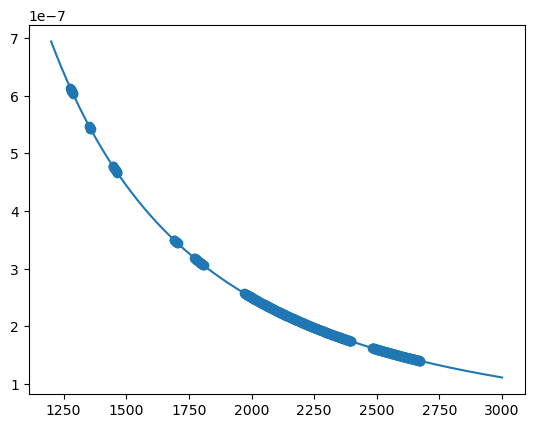

In [3]:
r1a, r1b = 1150,1170
r2a, r2b = 1275,1290
r3a, r3b = 1350,1360
r4a, r4b = 1445,1465
r5a, r5b = 1690,1705
r6a, r6b = 1770,1810
r7a, r7b = 1970,2400
r8a, r8b = 2480,2675
r9a, r9b = 2925,3400

As = [r2a,r3a,r4a,r5a,r6a,r7a,r8a]
Bs = [r2b,r3b,r4b,r5b,r6b,r7b,r8b]
wl = np.linspace(1200,3000,1000)
mask = np.zeros(len(wl),dtype=bool)
for i,m in enumerate(As):
    mask = np.logical_or(mask, (wl > As[i]) & (wl < Bs[i]))

popt,pcov = curve_fit(power_law, wl[mask], power_law(wl[mask],1,-2))


plt.scatter(wl[mask],power_law(wl[mask],1,-2))
plt.plot(wl,power_law(wl,*popt))
plt.show()

In [4]:
npath = '/media/bartosz/USB STICK/BOSS_DR14_ext/normed/'
epath = '/media/bartosz/USB STICK/BOSS_DR14_ext/'

spec_folder = ['spectra_07_2/','spectra_2_3/','spectra_3_4/']

In [5]:
#f = '/media/bartosz/USB STICK/BOSS_DR14/normed/6_spec-4354-55810-646_0_norm.txt'
cat_id,spec_id = [],[]
alpha,beta,alpha_sig,beta_sig = [],[],[],[]
failed_id = []
first,second = 0,0

for sf in spec_folder:
    
    for i,f in enumerate(glob.glob(epath + sf + 'fits/' + '*.txt')):
        # f = '/media/bartosz/USB STICK/BOSS_DR14/normed/6_spec-4354-55810-646_0_norm.txt'
    
        norm = np.loadtxt(f)
        wl,flux = norm[:,0],norm[:,1]
        # cnt = np.count_nonzero(sig==0)
        # print(cnt)
        # continue
        
        file_name = Path(f).stem
        file_info = file_name.split('_')
        
        mask = np.zeros(len(wl),dtype=bool)
        if 0 in flux[wl>r9a]:
            N = len(As)-1
        else: N = len(As)
            
        for j in range(N):
            mask = np.logical_or(mask, (wl > As[j]) & (wl < Bs[j]))
        # mask = np.logical_and(mask, sig>0)
    
        # # mask uncertainties >2sigma
        # sig_mean = np.mean(sig[mask])
        # sig_stdev = np.std(sig[mask])
        # mask = np.logical_and(mask,sig<sig_mean+3*sig_stdev)
        
        try:    
            #popt,pcov = curve_fit(power_law,wl[mask],flux[mask],sigma=sig[mask],absolute_sigma=True,maxfev=1000)
            popt,pcov = curve_fit(power_law,wl[mask],flux[mask],maxfev=1000)
            
        except RuntimeError:
            print(i, 'RuntimeError: 1st iteration')
            first += 1
            failed_id.append(file_info[0])
            continue
    
        diff = abs(flux - power_law(wl,*popt))
        diff_mean = np.mean(diff[mask])
        diff_stdev = np.std(diff[mask])
        mask2 = np.logical_and(mask,diff<diff_mean+3*diff_stdev)
    
        try:
            popt,pcov = curve_fit(power_law,wl[mask2],flux[mask2],maxfev=1000)
    
        except RuntimeError:
            print(i, 'RuntimeError: 2nd iteration; idx {}'.format(file_info[0]))
            second += 1
            failed_id.append(file_info[0])
            continue

        cat_id.append(int(file_info[0]))
        spec_id.append(file_info[1])
        
        alpha.append(popt[0])
        beta.append(popt[1])
        alpha_sig.append(np.sqrt(pcov[0][0]))
        beta_sig.append(np.sqrt(pcov[1][1]))
        
        print(i)

pl_save='power_law_fits_spline'
with open(epath + pl_save + '.txt','w') as plsave:
    for x in itertools.zip_longest(cat_id,spec_id,alpha,alpha_sig,beta,beta_sig):
        plsave.write('{} \t {} \t {} \t {} \t {} \t {} \n'.format(*x))
plsave.close()

print(first, '1st iteration RuntimeErrors; ', second, '2nd iteration RuntimeErrors')
print('index of failed spectra:')
for f in failed_id:
    print(f)

# plt.plot(wl[mask],flux[mask],drawstyle='steps-mid')
# plt.plot(wl,power_law(wl,*popt))
# plt.show()
# plt.plot(wl,flux/power_law(wl,*popt))
# plt.plot(wl,flux-power_law(wl,*popt))
# plt.show()

# print(cat_id,spec_id)




17170 RuntimeError: 2nd iteration; idx 169441
2363 RuntimeError: 1st iteration
1 1st iteration RuntimeErrors;  1 2nd iteration RuntimeErrors
index of failed spectra:
169441
168088


ValueError: 169441 is not in list

In [30]:
# pl_save='power_law_fits'
# with open(epath + pl_save + '.txt','w') as plsave:
#     for x in itertools.zip_longest(cat_id,spec_id,alpha,alpha_sig,beta,beta_sig):
#         plsave.write('{} \t {} \t {} \t {} \t {} \t {} \n'.format(*x))
# plsave.close()

In [6]:
pls = np.loadtxt(epath+'power_law_fits.txt',dtype='str')
pls=pls[:-1]
alphas,betas = np.array([float(a) for a in pls[:,2]]),np.array([float(b) for b in pls[:,4]])

alpha_sig = np.array([np.sqrt(float(s)) for s in pls[:,3]])
beta_sig = np.array([np.sqrt(float(s)) for s in pls[:,5]])

print(alpha_sig)
print(pls[:,0])

[ 6.521906   38.54523516 50.6610479  ... 26.84971733 62.04635308
  3.58446734]
['2943' '100018' '100025' ... '446835' '44688' '44752']


In [7]:
x = np.linspace(1200,3000,500)

slope =  np.array([alphas[i]*betas[i] for i in range(len(alphas))])
neg = slope < 0
pos = slope > 0
zer = slope == 0
print(len(alphas[neg]))
print(len(alphas[pos]))

49929
849


In [8]:
import random

sample = sorted(random.sample(range(len(pls[:,0])),100))

In [9]:
pp = PdfPages('plots/rand_sample.pdf')

for i,q in enumerate(pls[:,0][sample]):
    #plt.plot(x,power_law(x,float(alphas[pos][i]),float(betas[pos][i])))
    spec = np.loadtxt(glob.glob(npath + '{}_*.txt'.format(q))[0])
    wl,flux,sig = spec[:,0],spec[:,1],spec[:,2]

    median = np.median(flux)
    stdev = np.std(flux)
    mask = abs(flux)<median+5*stdev

    # mask = np.zeros(len(wl),dtype=bool)
    # for j,m in enumerate(As):
    #     mask = np.logical_or(mask, (wl > As[j]) & (wl < Bs[j]))
    # mask = np.logical_and(mask, sig>0)
    
    # # mask uncertainties >2sigma
    # sig_mean = np.mean(sig[mask])
    # sig_stdev = np.std(sig[mask])
    # mask = sig<sig_mean+2*sig_stdev

    fig = plt.figure()
    plt.title(q)
    plt.plot(wl[mask],flux[mask],drawstyle='steps-mid',lw=0.5)
    plt.plot(wl[mask],power_law(wl[mask],alphas[sample][i],betas[sample][i]),alpha=0.7,lw=0.5)
    plt.plot(wl[mask],flux[mask]-power_law(wl[mask],alphas[sample][i],betas[sample][i]),drawstyle='steps-mid',alpha=0.7,lw=0.5)
    plt.plot(wl[mask],sig[mask]-1,drawstyle='steps-mid',alpha=0.5,lw=0.5)
    for j,a in enumerate(As):
        plt.axvspan(As[j],Bs[j],color='lightgrey')
    plt.xlabel('wavelength')
    pp.savefig(fig)
    plt.close()

pp.close()

0

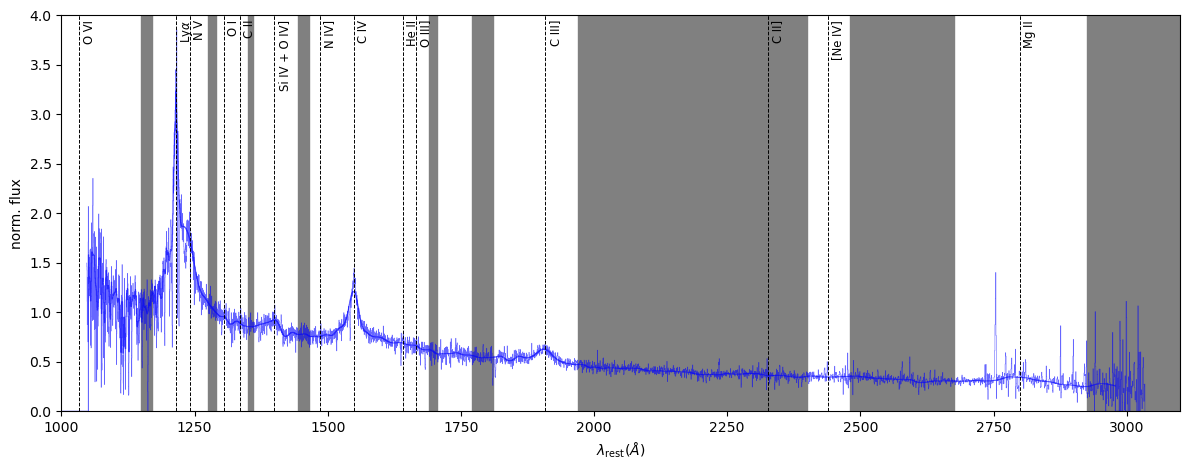